In [1]:
import pandas as pd

import glob

from pathlib import Path
import csv

import glob

In [2]:
# Machine-learning specific imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import model_from_json

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [3]:
## API Imports 
import os
import requests
import json

from dotenv import load_dotenv
load_dotenv()

True

In [4]:
## Load pickle for exports and imports of data  
import pickle 
def load_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
def save_obj(obj, path ):
    with open(path, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [5]:
## FMP Constants 
fmpbase_urlv3 = 'https://fmpcloud.io/api/v3/'
fmpbase_urlv4 = 'https://fmpcloud.io/api/v4/'
api_key = os.getenv("FMP_CLOUD_API_KEY")

start_date = '2022-01-01'
end_date = '2022-01-31'

## FMP Functions 
def get_FMP_historical_data(symbol, startDate=start_date, endDate=end_date, apiKey=api_key):
    url_hist_price = fmpbase_urlv3+'historical-price-full/'
    url_hist_query_with_date = url_hist_price+symbol+'?from='+startDate+'&to='+endDate+'&apikey='+apiKey
    resp_data = requests.get(url_hist_query_with_date)
    json_ = resp_data.json()
    data = json_['historical']
    df = pd.DataFrame(data)
    df.rename(columns={'date':'Date'},inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.reindex(index=df.index[::-1]) ## Reverse the DataFrame 
    df.set_index('Date',inplace=True)
    df.drop(columns='label',inplace=True)
    return df

In [6]:
def get_data(symbol, n_days):
    path = Path('../FilesExport_Complete_DFs_TI_noShift/'+symbol+'_TI_DF_no_shift.pkl')
    data = load_obj(path)
    df = data[symbol]
    
    df_close = df[['close']]
    df_close = df_close.reset_index().rename(columns={"Date": "Close_Date"})
    
    features_df = df.reset_index().drop(columns=['close','adjClose'])
    
    new_close_df = df_close.iloc[n_days: , :].reset_index(drop=True)
    
    ## Prevent multiple API calls each time, but use API when needed. 
    try:
        path = Path('../FilesExport_Updated_API_data/'+symbol+'_jan_2022.pkl')
        api_df = load_obj(path)
    except:
        api_df = get_FMP_historical_data(symbol)
    

    new_data = api_df[['close']]
    new_data = new_data.reset_index().rename(columns={"Date": "Close_Date"})
    new_data = new_data.iloc[0:n_days]
    
    new_close_df = new_close_df.append(new_data, ignore_index=True)
    

    
    return features_df, new_close_df

## Dropping QUANTITY_FAILS from dataframe before machine learning 

def prepare_data_no_FTD(symbol,n_days,return_data=False):
    features_df, new_close_df = get_data(symbol,n_days)
    
    X = features_df.drop(columns={'Date','QUANTITY_FAILS'}).values
    y = new_close_df['close'].values
    
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    
    if return_data == True:
        return X, y, features_df, new_close_df
    else:
        return X, y
    
def prepare_data(symbol,n_days,return_data=False):
    features_df, new_close_df = get_data(symbol,n_days)
    
    X = features_df.drop(columns='Date').values
    y = new_close_df['close'].values
    
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    
    if return_data == True:
        return X, y, features_df, new_close_df
    else:
        return X, y

17.057640075683594
16.72842788696289


<AxesSubplot:xlabel='Close_Date'>

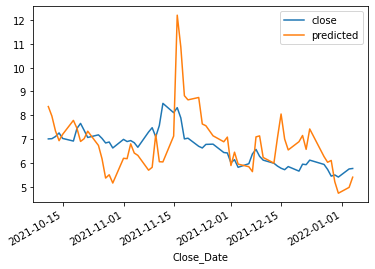

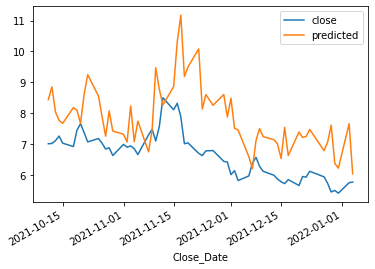

In [53]:
n_days = 2
symbol = 'ACB'
days_to_plot = 60

export_path='../Model_Data/Date_Test_NN_w_FTD_all/Low_Acc/'
model_type = 'NN'
n_days_string = str(n_days)
export_path_prefix = export_path+symbol+'_'+model_type+'_'+n_days_string

file_path = Path(export_path_prefix+'_model_data.json')
with open(file_path, "r") as json_file:
    model_json = json_file.read()
loaded_model = model_from_json(model_json)

# load weights into new model
file_path = Path(export_path_prefix+'_model_weights.h5')
loaded_model.load_weights(file_path)

## Load model summary 
file_path = Path(export_path_prefix+'_model_summary.pkl')
model_summary = load_obj(file_path)

X , y, features, close_df = prepare_data_no_FTD(symbol,n_days,return_data=True)


close_df["predicted"] = loaded_model.predict(X)
close_df.set_index('Close_Date',inplace=True)

print(model_summary['model_accuracy'])

close_df[['close','predicted']].tail(days_to_plot).plot(use_index=True)




export_path='../Model_Data/Date_Test_NN_w_FTD_all/Low_Acc/'
model_type = 'NN'
n_days_string = str(n_days)
export_path_prefix = export_path+symbol+'_'+model_type+'_'+n_days_string

file_path = Path(export_path_prefix+'_model_data.json')
with open(file_path, "r") as json_file:
    model_json = json_file.read()
loaded_model2 = model_from_json(model_json)

# load weights into new model
file_path = Path(export_path_prefix+'_model_weights.h5')
loaded_model2.load_weights(file_path)

## Load model summary 
file_path = Path(export_path_prefix+'_model_summary.pkl')
model_summary2 = load_obj(file_path)

X2 , y2, features2, close_df2 = prepare_data(symbol,n_days,return_data=True)

close_df2["predicted"] = loaded_model2.predict(X2)
close_df2.set_index('Close_Date',inplace=True)

print(model_summary2['model_accuracy'])

close_df2[['close','predicted']].tail(days_to_plot).plot(use_index=True)

In [ ]:
model_summary

In [ ]:
model_summary2

In [ ]:
# n_days = 2
# symbol = 'ACB'
# days_to_plot = 60

export_path='../Model_Data/Date_Test_NN_w_FTD_all/High_Acc/'
model_type = 'NN'
n_days_string = str(n_days)
export_path_prefix = export_path+symbol+'_'+model_type+'_'+n_days_string

file_path = Path(export_path_prefix+'_model_data.json')
with open(file_path, "r") as json_file:
    model_json = json_file.read()
loaded_model = model_from_json(model_json)

# load weights into new model
file_path = Path(export_path_prefix+'_model_weights.h5')
loaded_model.load_weights(file_path)

## Load model summary 
file_path = Path(export_path_prefix+'_model_summary.pkl')
model_summary = load_obj(file_path)

X , y, features, close_df = prepare_data_no_FTD(symbol,n_days,return_data=True)


close_df["predicted"] = loaded_model.predict(X)
close_df.set_index('Close_Date',inplace=True)

print(model_summary['model_accuracy'])

close_df[['close','predicted']].tail(days_to_plot).plot(use_index=True)




export_path='../Model_Data/Date_Test_NN_w_FTD_all/High_Acc/'
model_type = 'NN'
n_days_string = str(n_days)
export_path_prefix = export_path+symbol+'_'+model_type+'_'+n_days_string

file_path = Path(export_path_prefix+'_model_data.json')
with open(file_path, "r") as json_file:
    model_json = json_file.read()
loaded_model2 = model_from_json(model_json)

# load weights into new model
file_path = Path(export_path_prefix+'_model_weights.h5')
loaded_model2.load_weights(file_path)

## Load model summary 
file_path = Path(export_path_prefix+'_model_summary.pkl')
model_summary2 = load_obj(file_path)

X2 , y2, features2, close_df2 = prepare_data(symbol,n_days,return_data=True)

close_df2["predicted"] = loaded_model2.predict(X2)
close_df2.set_index('Close_Date',inplace=True)

print(model_summary2['model_accuracy'])

close_df2[['close','predicted']].tail(days_to_plot).plot(use_index=True)

In [54]:
model_summary

{'model_accuracy': 17.057640075683594,
 'n_days': 2,
 'validation_split_value': 0.1,
 'epochs_value': 200}

In [55]:
model_summary2

{'model_accuracy': 16.72842788696289,
 'n_days': 2,
 'validation_split_value': 0.1,
 'epochs_value': 200}